# Zero Temperature Wang-Parr inversion test
## $\rm H_2$
Code for thermal interacting tools comes from V. Martinetto, Modified for general use and published as a package by A. R. Osborne


In [23]:
import numpy as np
import scipy.sparse as spa
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from scipy.integrate import simpson as simps
import matplotlib.animation as animation
from IPython.display import HTML
import iDEA
import math
from matplotlib import cm
import scipy
from decimal import Decimal
from tools import thermal_interacting_tools as tit
import inspect
import pickle

In [24]:
Save = True
Load = False

## Set up system

In [2]:
x = np.linspace(-5, 5, 101)
# v_ext = tit.v_diatomic(1, x, 1.4)
v_ext = tit.atomic_potentials(1, x, 1.4, potential_type = 2)
v_int = iDEA.interactions.softened_interaction(x)#, softening=0.1)
s = iDEA.system.System(x, v_ext, v_int, 'ud')

## Solve interacting System in the forward direction

In [3]:
state = iDEA.methods.interacting.solve(s, k=0)

iDEA.methods.interacting.solve: solving eigenproblem...


### Extract the density observable 
Integrate it to ensure the correct number of particles is being used.

In [4]:
n = iDEA.observables.density(s, state)
num_particles = np.trapz(n, x)
print(num_particles)

1.9999972939194939


### Plot density for a nice visual

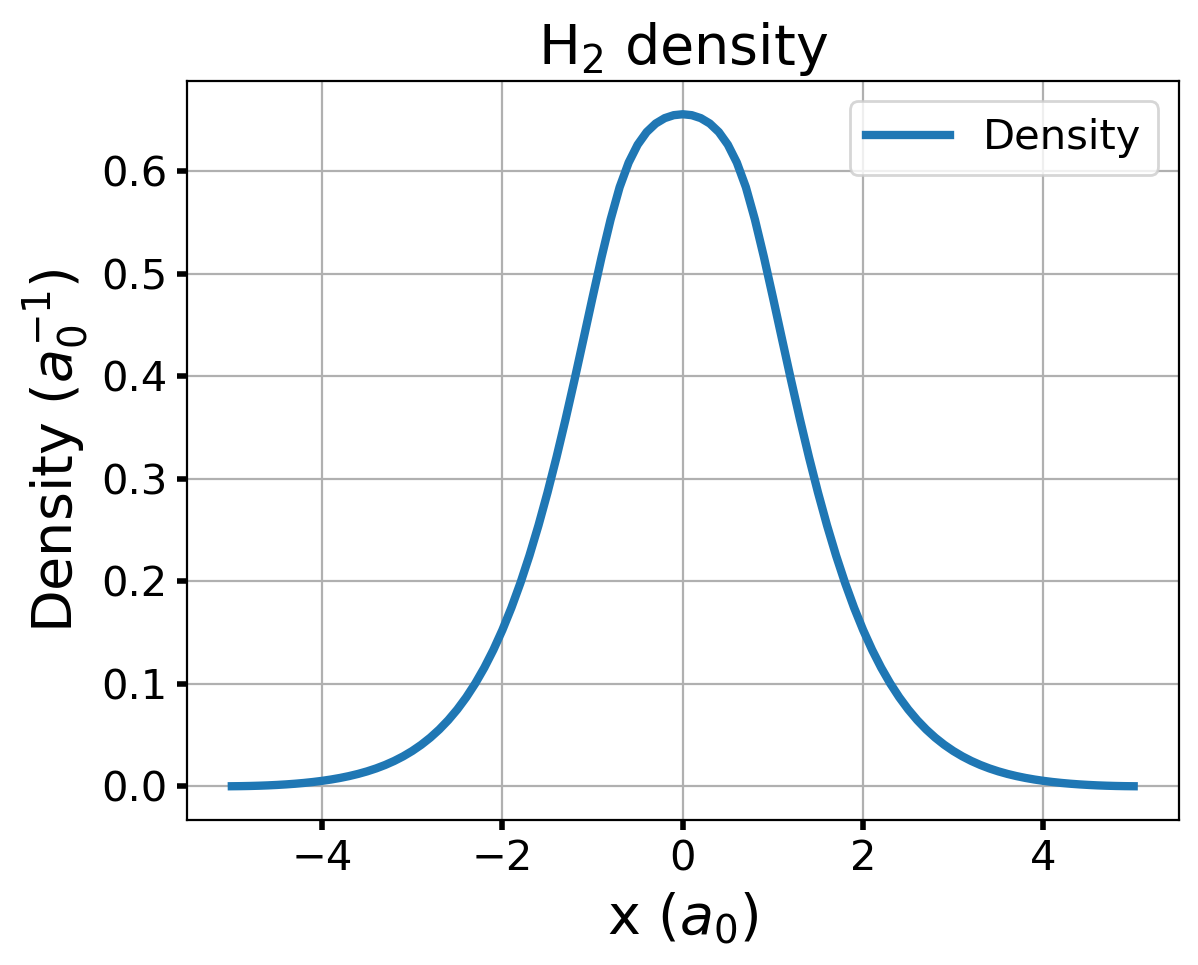

In [5]:
#---------------> Plot
fig, ax = plt.subplots(1, 1, dpi=200)
#---------------> Data
ax.plot(x, n, linewidth=3, label="Density")
#---------------> Formatting
ax.set_title(r"$\rm H_2$ density", fontsize = 20)
ax.set_ylabel(r"Density ($a_0^{-1}$)", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Invert density using the available methods
It is possible to lower the tolerance if one wants increased speed. Although 1e-12 gives a more accurate answer

### Scheme from Rex Godby

In [6]:
s_fictitious_godby = iDEA.reverse_engineering.reverse(s, target_n=n, method=iDEA.methods.non_interacting, scheme=1, tol=1e-6)
state_fictitious_godby = iDEA.methods.non_interacting.solve(s_fictitious_godby, k=0)


v_ks_godby = s_fictitious_godby.v_ext
n_fictitious_godby = iDEA.observables.density(s, state_fictitious_godby)
v_h_godby = iDEA.observables.hartree_potential(s_fictitious_godby, n_fictitious_godby)
v_xc_godby = v_ks_godby - s.v_ext - v_h_godby

iDEA.Godby_inversion: convergence = 1.0011e-06, tolerance = 1e-06
iDEA.methods.non_interacting.solve: convergence = 5.721e-12, tolerance = 1e-10


In [7]:
# test_state = iDEA.methods.non_interacting.solve(s, k=0)
# test_energy = iDEA.methods.non_interacting.total_energy(s, test_state)
# orbitals = test_state.up.orbitals
# print(s.count)
# # test_state = iDEA.methods.hybrid.solve(s, k=0)

In [8]:
# print(state.energy)
# print(test_energy)
# print(test_state.up.energies[0])

In [9]:
# density = np.zeros(len(orbitals))
# density += (2*abs(orbitals[:,0]**2))

In [10]:
# #---------------> Plot
# fig, ax = plt.subplots(1, 1, dpi=200)
# #---------------> Data
# ax.plot(x, n, linewidth=3, label="Density")
# ax.plot(x, density, linewidth=3, label='non-interacting')
# # ax.plot(x, )
# # ax.plot(x, test_state.up.orbitals[:,0], linewidth=3, label="non interacting Density")
# # ax.plot(x, test_state.down.orbitals[:,0], linewidth=3, label="non interacting Density")
# #---------------> Formatting
# ax.set_title(r"1D He density", fontsize = 20)
# ax.set_ylabel(r"Density ($a_0^{-1}$)", fontsize = 20)
# ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
# ax.grid(True)
# ax.legend(loc="best", fontsize=15)
# ax.xaxis.set_tick_params(width=2)
# ax.yaxis.set_tick_params(width=2)
# #-------> Borders ## Have to run cell twice for this to work no idea why -- AO
# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 2.0
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.show()

### Wang-Parr scheme
with lowered tolerance to check if method works at all.

In [11]:
s_fictitious_wp = iDEA.reverse_engineering.reverse(s, target_n=n, method=iDEA.methods.non_interacting, scheme=2, tol=1e-6)
state_fictitious_wp = iDEA.methods.non_interacting.solve(s_fictitious_wp, k=0)
v_ks_wp = s_fictitious_wp.v_ext
n_fictitious_wp = iDEA.observables.density(s, state_fictitious_wp)
v_h_wp = iDEA.observables.hartree_potential(s_fictitious_wp, n_fictitious_wp)
v_xc_wp = v_ks_wp - s.v_ext - v_h_wp

iDEA.Wang-Parr_inversion: convergence = 1.0002e-06, tolerance = 1e-06
iDEA.methods.non_interacting.solve: convergence = 5.5639e-12, tolerance = 1e-10


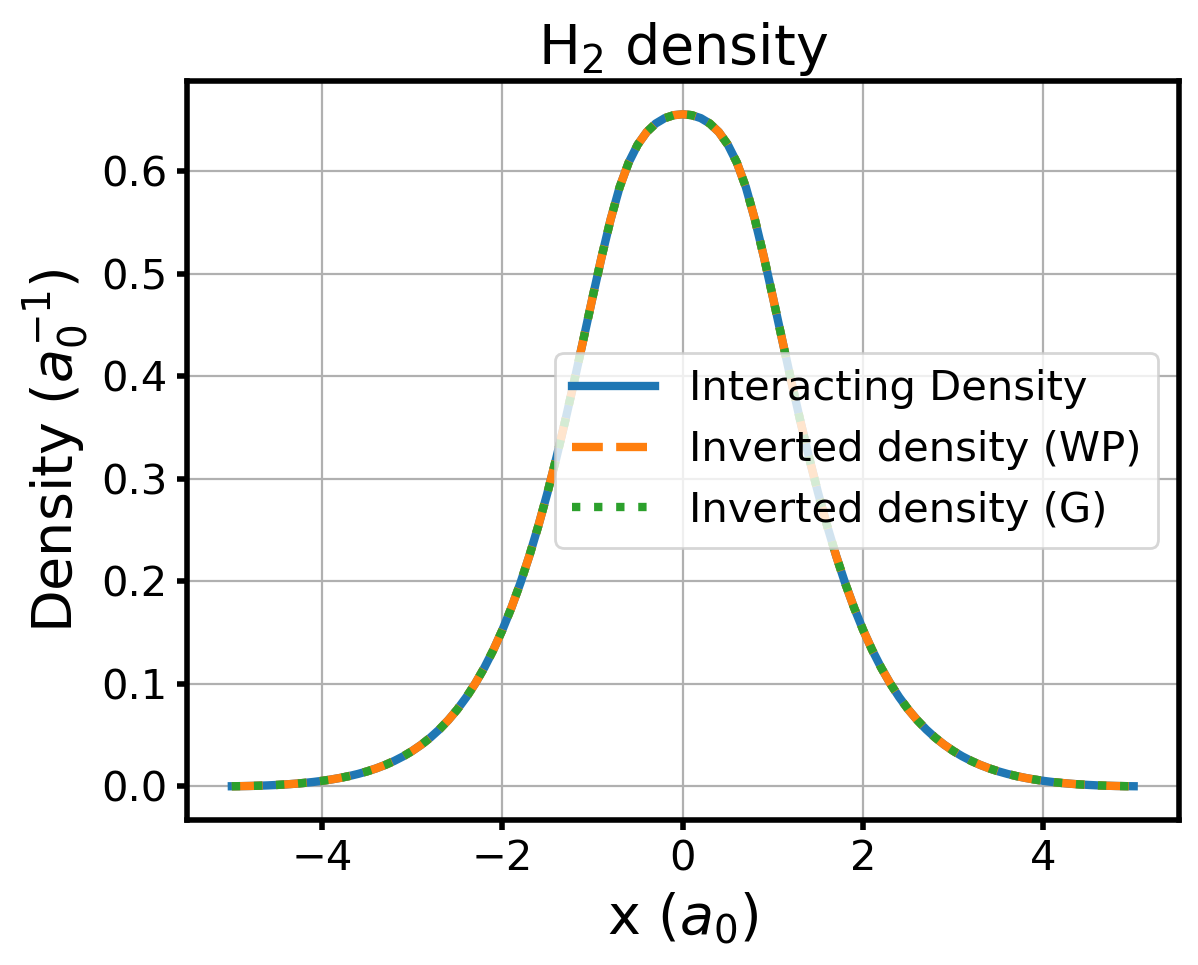

In [12]:
#---------------> Plot
fig, ax = plt.subplots(1, 1, dpi=200)
#---------------> Data
ax.plot(x, n, linewidth=3, label="Interacting Density")
ax.plot(x, n_fictitious_wp, linewidth=3, label='Inverted density (WP)',ls='--')
ax.plot(x, n_fictitious_godby, linewidth=3, label='Inverted density (G)',ls=':')
#---------------> Formatting
ax.set_title(r"$\rm H_2$ density", fontsize = 20)
ax.set_ylabel(r"Density ($a_0^{-1}$)", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

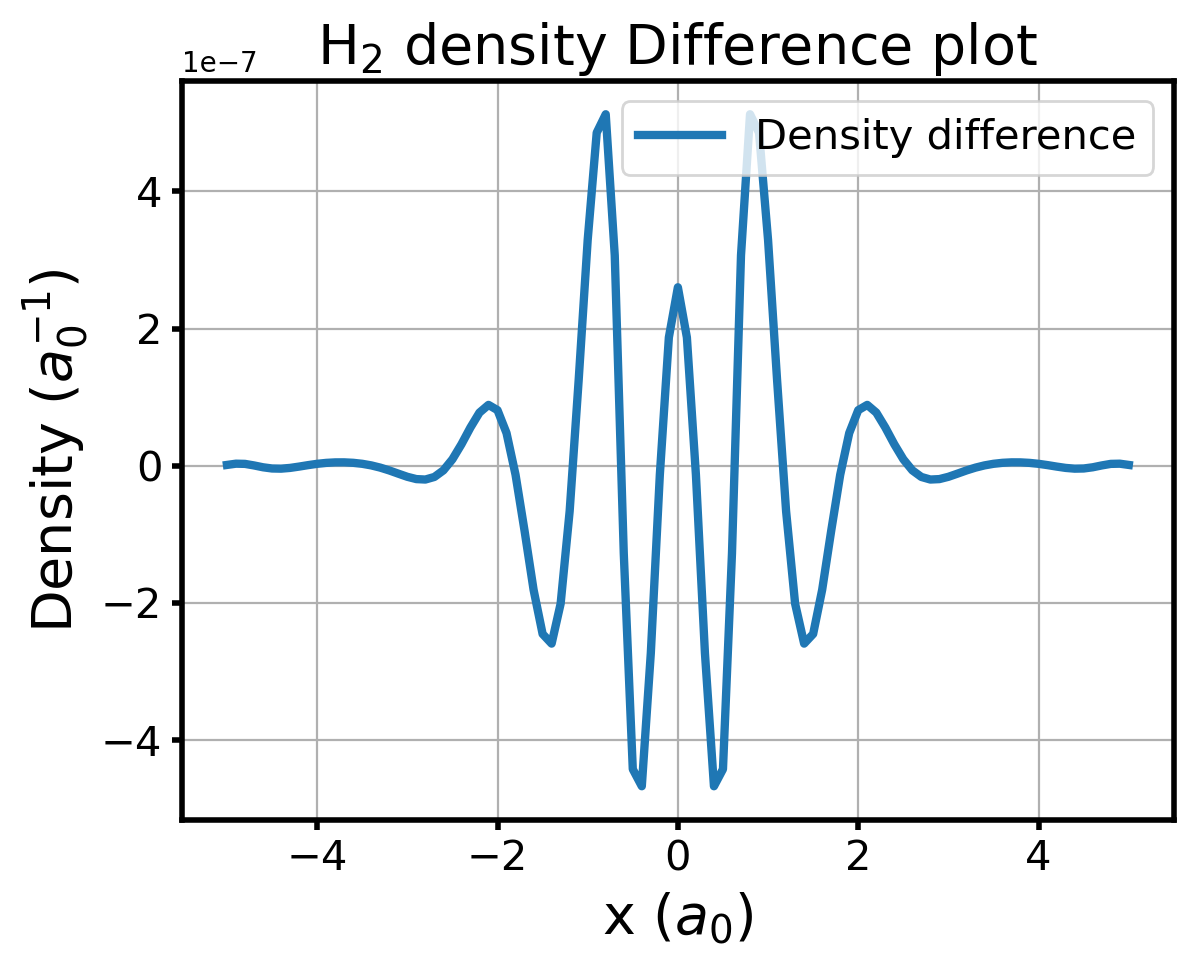

In [13]:
#---------------> Plot
fig, ax = plt.subplots(1, 1, dpi=200)
#---------------> Data
ax.plot(x, n-n_fictitious_wp, linewidth=3, label="Density difference")
# ax.plot(x, n_fictitious_wp, linewidth=3, label='Inverted density',ls='--')
#---------------> Formatting
ax.set_title(r"$\rm H_2$ density Difference plot", fontsize = 20)
ax.set_ylabel(r"Density ($a_0^{-1}$)", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [14]:
#v_xc_wp = v_ks_wp - s.v_ext - v_h_wp

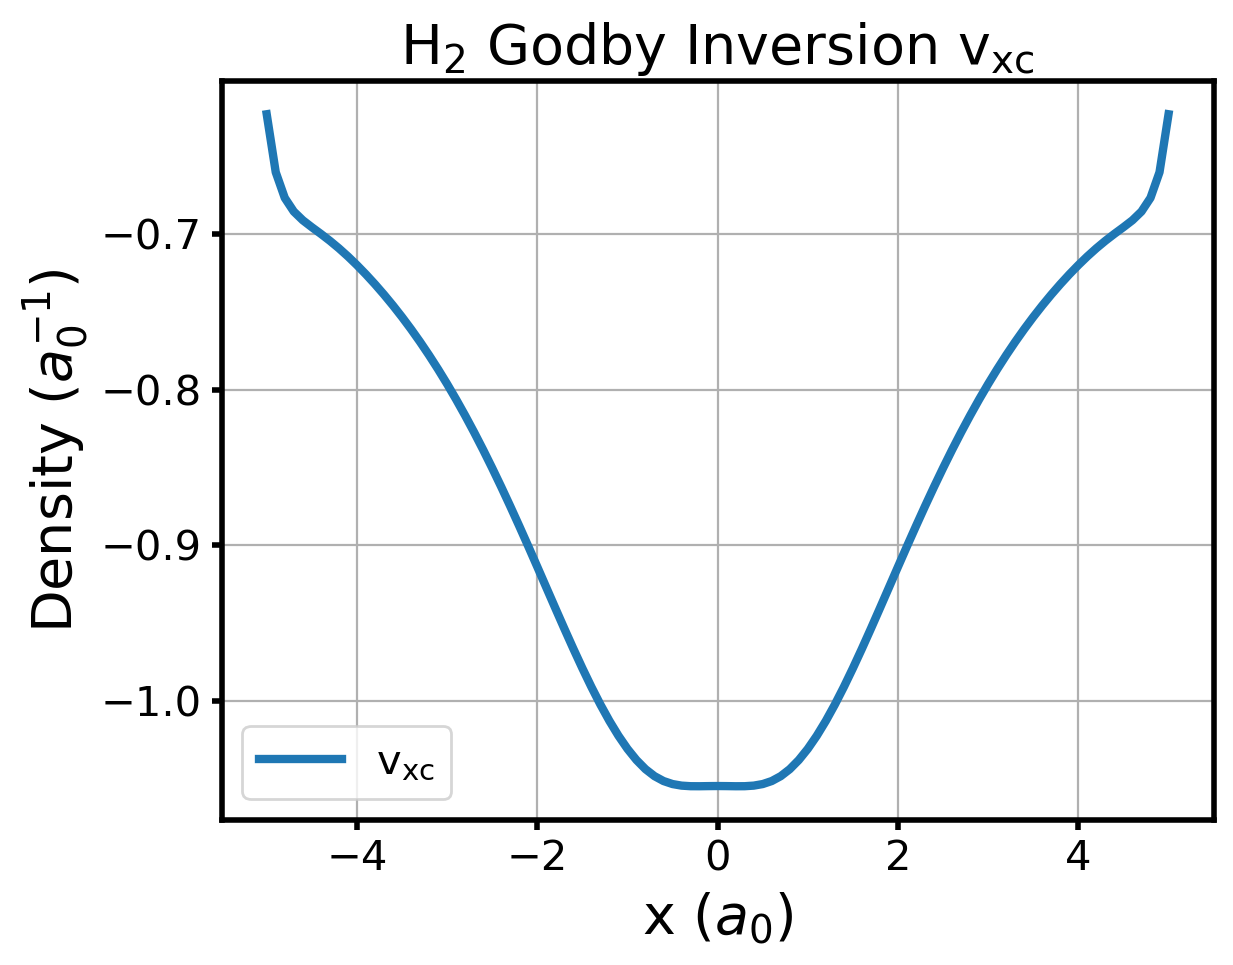

In [15]:
#---------------> Plot
fig, ax = plt.subplots(1, 1, dpi=200)
#---------------> Data
# ax.plot(x, n_fictitious_wp, linewidth=3, label="Inverted Density")
ax.plot(x, v_xc_godby, linewidth=3, label=r'$\rm v_{xc}$')
# ax.plot(x, v_ks_godby, linewidth=3, label=r'$\rm v_{ks}$')
# ax.plot(x, v_h_godby, linewidth=3, label=r'$\rm v_{H}$')
# ax.plot(x, s.v_ext, linewidth=3, label=r'$\rm v_{ext}$')
#---------------> Formatting
ax.set_title(r"$\rm H_2$ Godby Inversion $\rm v_{xc}$", fontsize = 20)
ax.set_ylabel(r"Density ($a_0^{-1}$)", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

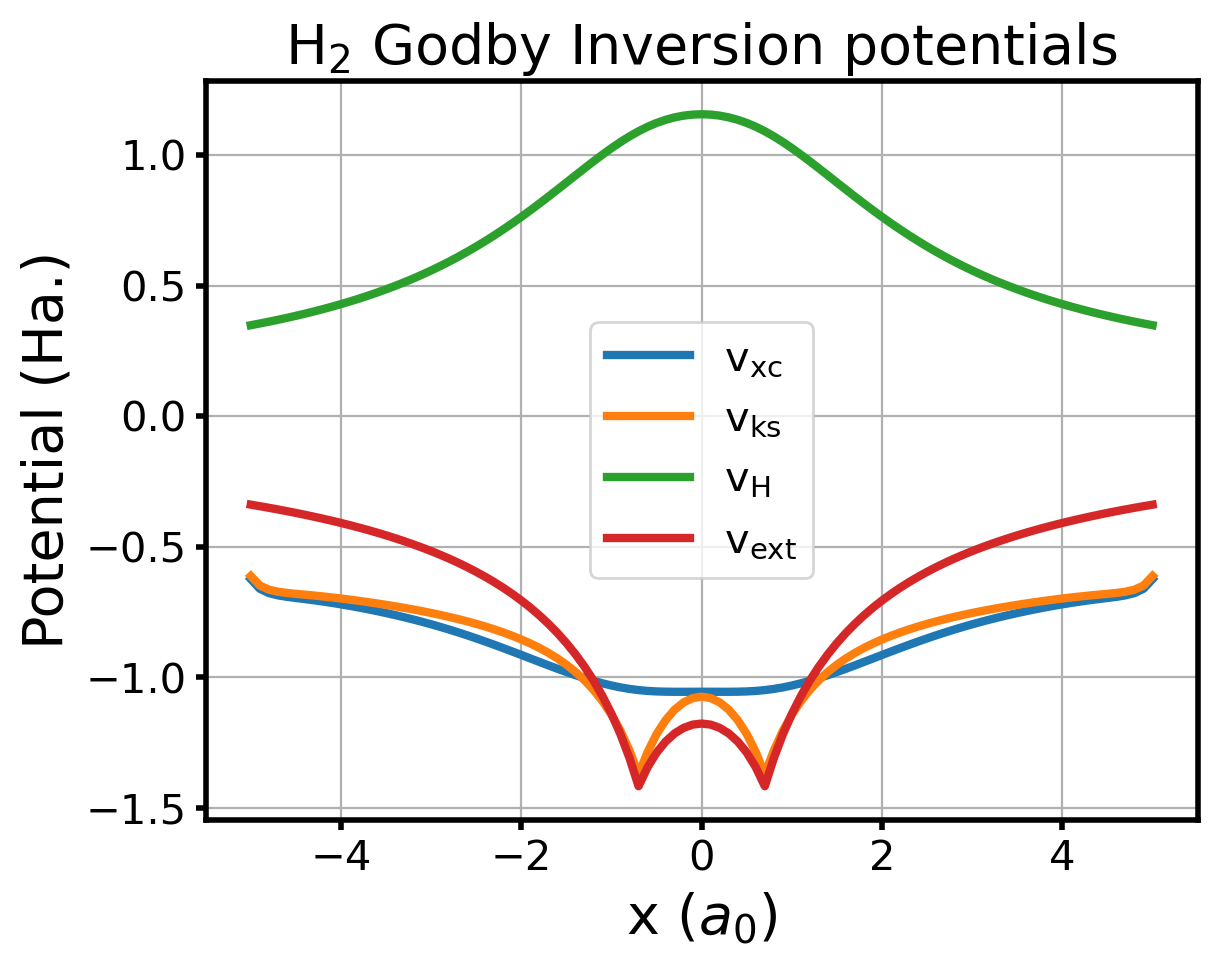

In [16]:
#---------------> Plot
fig, ax = plt.subplots(1, 1, dpi=200)
#---------------> Data
# ax.plot(x, n_fictitious_wp, linewidth=3, label="Inverted Density")
ax.plot(x, v_xc_godby, linewidth=3, label=r'$\rm v_{xc}$')
ax.plot(x, v_ks_godby, linewidth=3, label=r'$\rm v_{ks}$')
ax.plot(x, v_h_godby, linewidth=3, label=r'$\rm v_{H}$')
ax.plot(x, s.v_ext, linewidth=3, label=r'$\rm v_{ext}$')
#---------------> Formatting
ax.set_title(r"$\rm H_2$ Godby Inversion potentials", fontsize = 20)
ax.set_ylabel(r"Potential (Ha.)", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

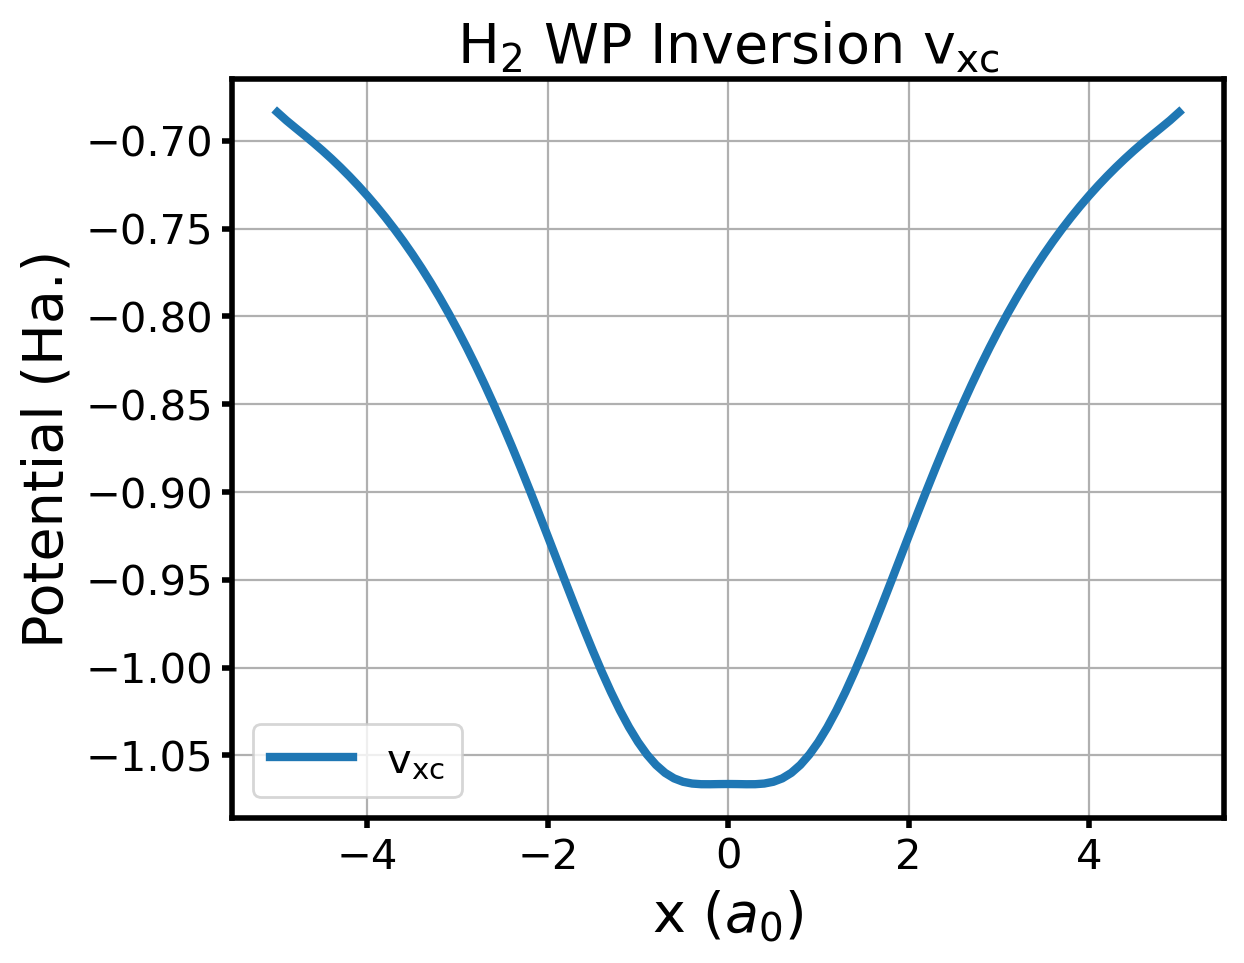

In [17]:
#---------------> Plot
fig, ax = plt.subplots(1, 1, dpi=200)
#---------------> Data
# ax.plot(x, n_fictitious_wp, linewidth=3, label="Inverted Density")
ax.plot(x, v_xc_wp, linewidth=3, label=r'$\rm v_{xc}$')
# ax.plot(x, v_ks_wp, linewidth=3, label=r'$\rm v_{ks}$')
# ax.plot(x, v_h_wp, linewidth=3, label=r'$\rm v_{H}$')
# ax.plot(x, s.v_ext, linewidth=3, label=r'$\rm v_{ext}$')
#---------------> Formatting
ax.set_title(r"$\rm H_2$ WP Inversion $\rm v_{xc}$", fontsize = 20)
ax.set_ylabel(r"Potential (Ha.)", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

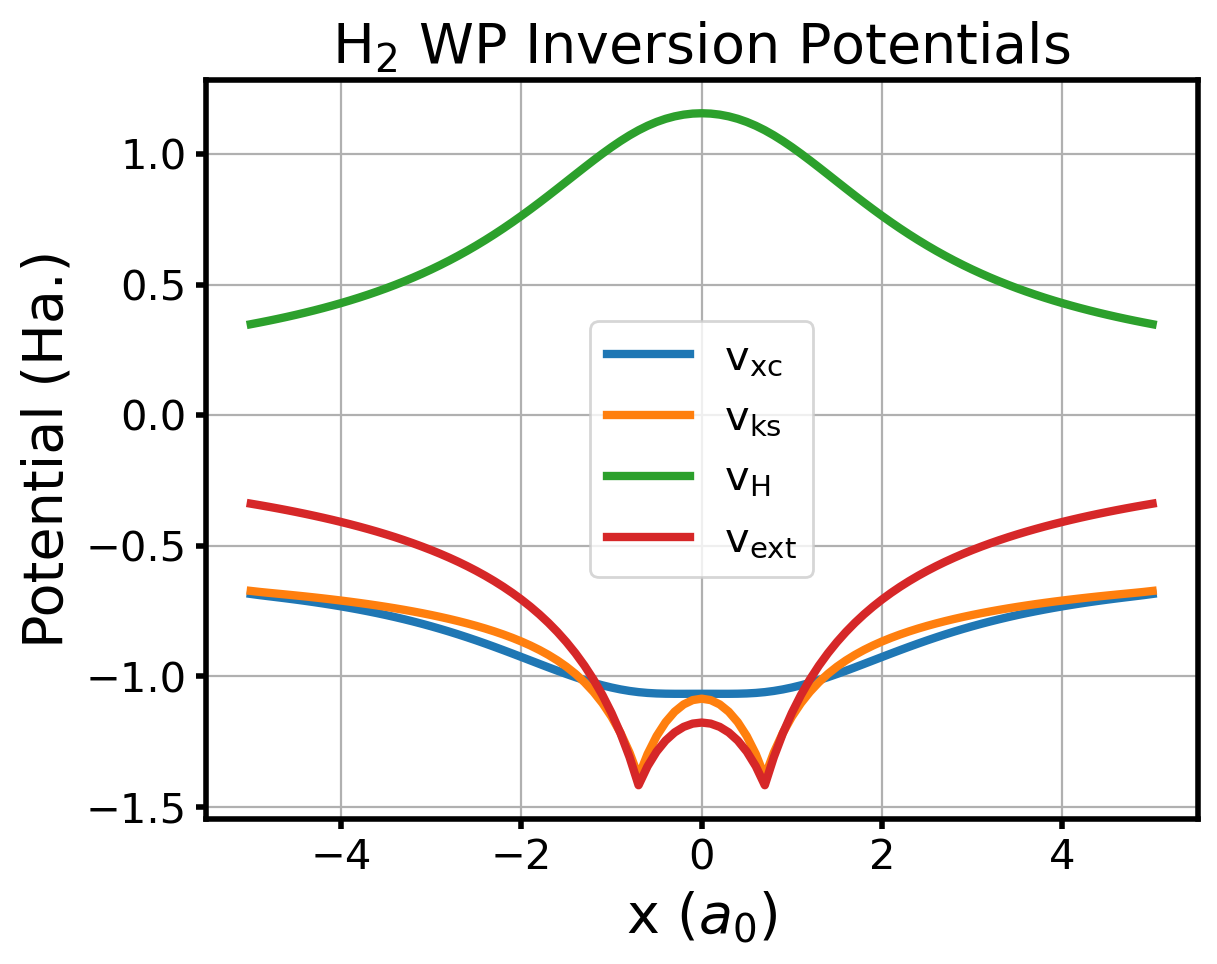

In [18]:
#---------------> Plot
fig, ax = plt.subplots(1, 1, dpi=200)
#---------------> Data
# ax.plot(x, n_fictitious_wp, linewidth=3, label="Inverted Density")
ax.plot(x, v_xc_wp, linewidth=3, label=r'$\rm v_{xc}$')
ax.plot(x, v_ks_wp, linewidth=3, label=r'$\rm v_{ks}$')
ax.plot(x, v_h_wp, linewidth=3, label=r'$\rm v_{H}$')

ax.plot(x, s.v_ext, linewidth=3, label=r'$\rm v_{ext}$')
#---------------> Formatting
ax.set_title(r"$\rm H_2$ WP Inversion Potentials", fontsize = 20)
ax.set_ylabel(r"Potential (Ha.)", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

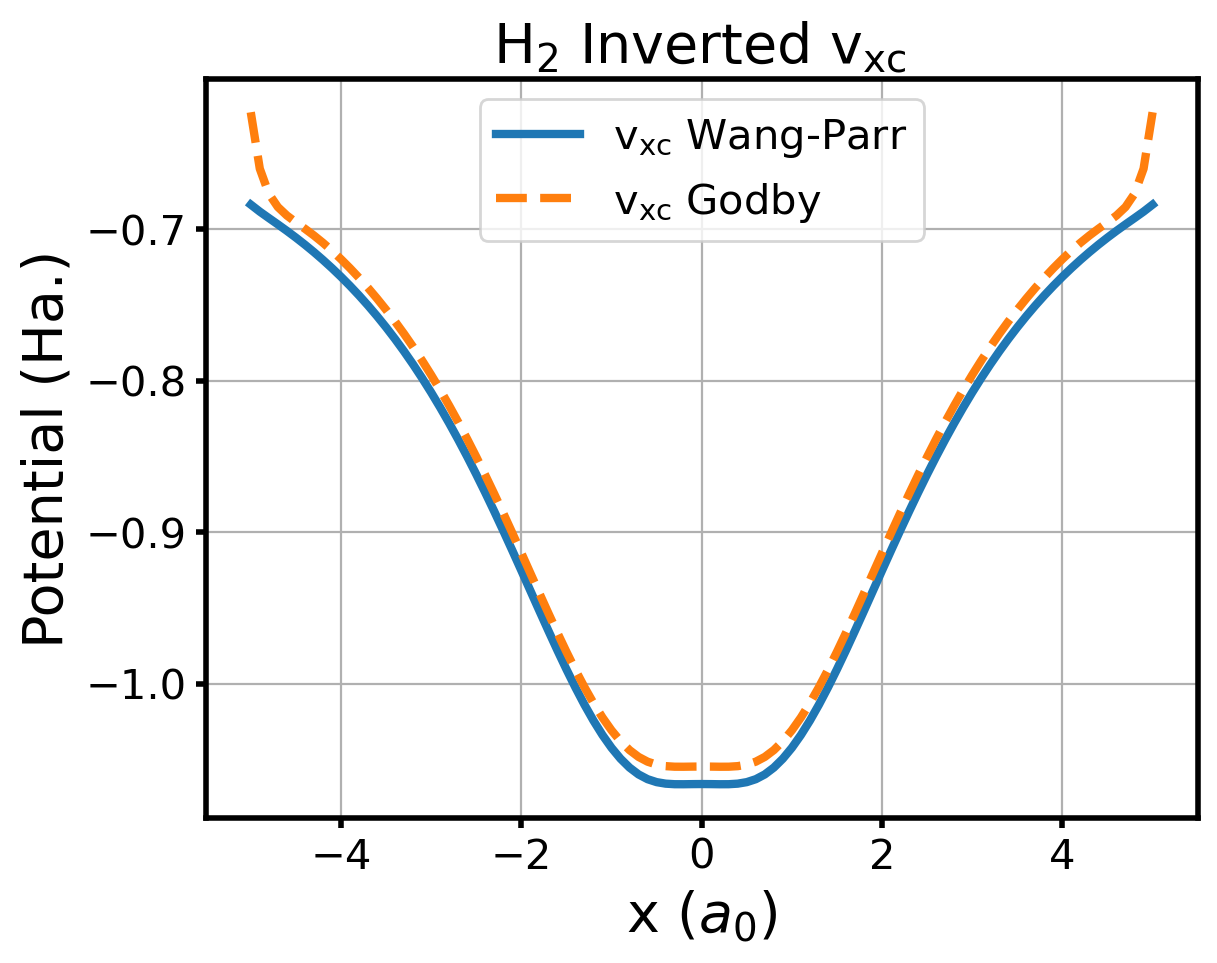

In [19]:
#---------------> Plot
fig, ax = plt.subplots(1, 1, dpi=200)
#---------------> Data
# ax.plot(x, n_fictitious_wp, linewidth=3, label="Inverted Density")
ax.plot(x, v_xc_wp, ls='-', linewidth=3, label=r'$\rm v_{xc}$ Wang-Parr')
# ax.plot(x, v_ks_wp, linewidth=3, label=r'$\rm v_{ks}$')
# ax.plot(x, v_h_wp, linewidth=3, label=r'$\rm v_{H}$')
ax.plot(x, v_xc_godby, linewidth=3, label=r'$\rm v_{xc}$ Godby', ls='--')
# ax.plot(x, v_ks_godby, linewidth=3, label=r'$\rm v_{ks}G$', ls='--')
# ax.plot(x, v_h_godby, linewidth=3, label=r'$\rm v_{H}G$', ls='--')
# ax.plot(x, s.v_ext, linewidth=3, label=r'$\rm v_{ext}$', ls='--')
#---------------> Formatting
ax.set_title(r"$\rm H_2$ Inverted $\rm v_{xc}$ ", fontsize = 20)
ax.set_ylabel(r"Potential (Ha.)", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

/var/folders/ds/n2806b452yv63hlbjdqg20400000gp/T/ipykernel_5721/1712381691.py:4: RuntimeWarning: divide by zero encountered in divide
  ax.plot(x, -1/abs(x) + 1/5, label=r"$-\frac{1}{x}$", linewidth=3)


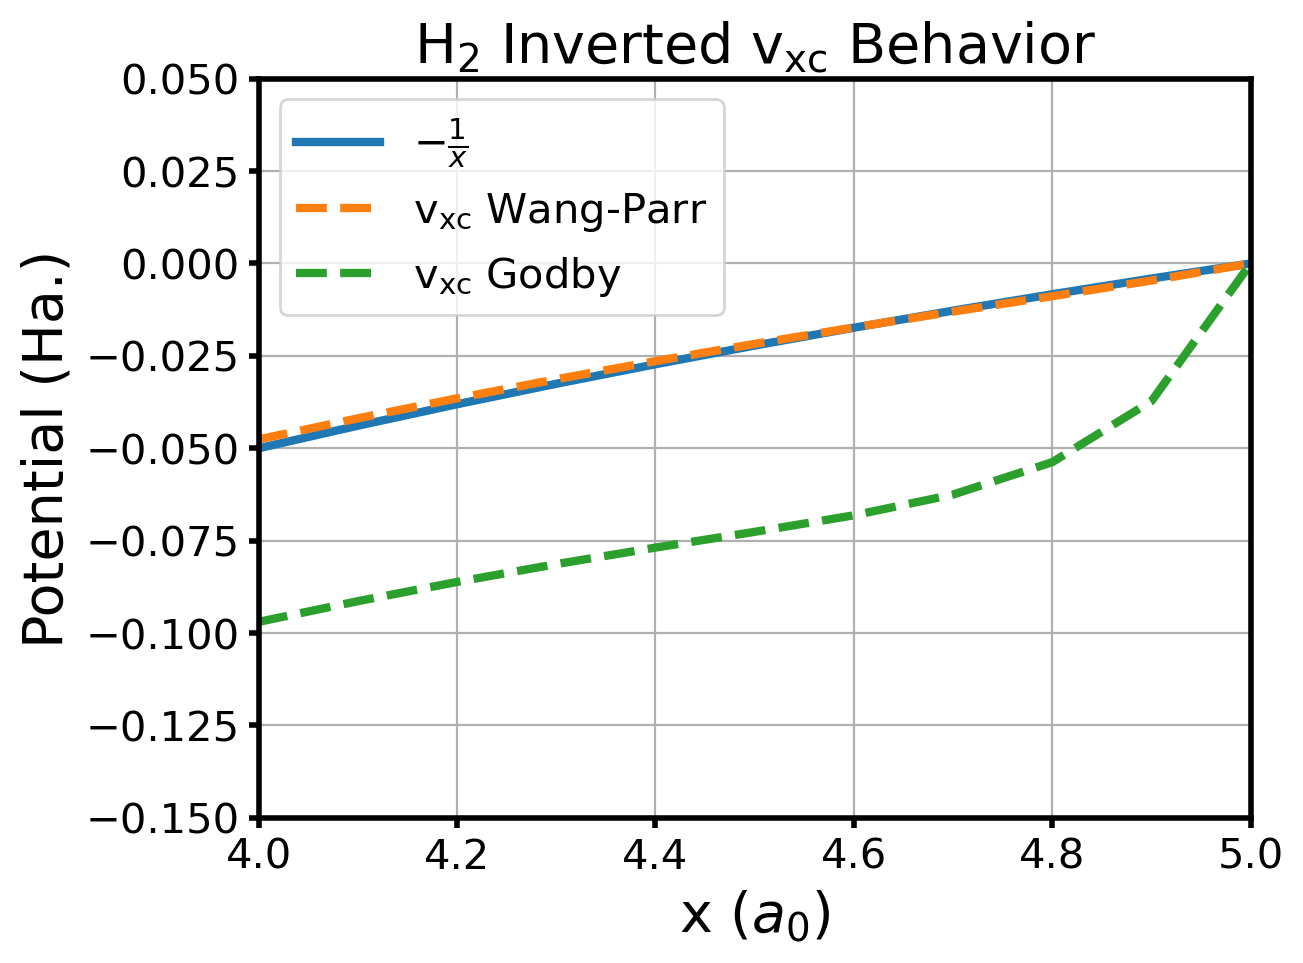

In [20]:
#---------------> Plot
fig, ax = plt.subplots(1, 1, dpi=200)
#---------------> Data
ax.plot(x, -1/abs(x) + 1/5, label=r"$-\frac{1}{x}$", linewidth=3)
ax.plot(x, v_xc_wp -v_xc_wp[100], ls='--', linewidth=3, label=r'$\rm v_{xc}$ Wang-Parr')
ax.plot(x, v_xc_godby + ((-v_xc_godby[100])), linewidth=3, label=r'$\rm v_{xc}$ Godby', ls='--')
#---------------> Formatting
ax.set_title(r"$\rm H_2$ Inverted $\rm v_{xc}$ Behavior ", fontsize = 20)
ax.set_ylabel(r"Potential (Ha.)", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.set_ylim(-0.15, 0.05)
ax.set_xlim(4, 5)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

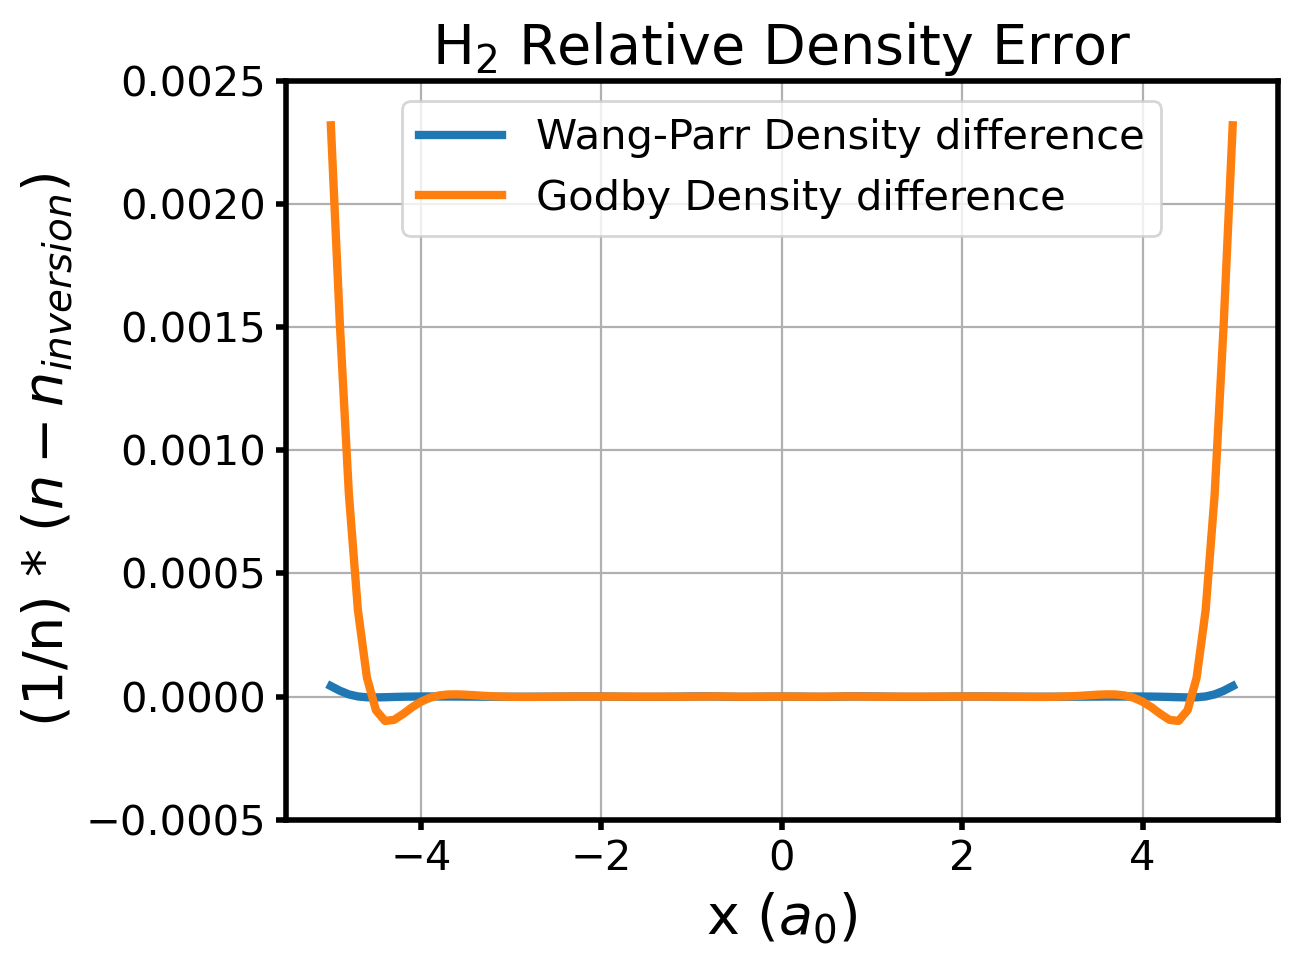

In [21]:
#---------------> Plot
fig, ax = plt.subplots(1, 1, dpi=200)
#---------------> Data
ax.plot(x, (1/n) * (n-n_fictitious_wp), linewidth=3, label="Wang-Parr Density difference")
ax.plot(x, (1/n) * (n-n_fictitious_godby), linewidth=3, label="Godby Density difference")
# ax.plot(x, n_fictitious_wp, linewidth=3, label='Inverted density',ls='--')
#---------------> Formatting
ax.set_title(r"$\rm H_2$ Relative Density Error", fontsize = 20)
ax.set_ylabel(r"(1/n) * ($n-n_{inversion}$)", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.set_ylim(-0.0005, 0.0025)
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [22]:
print(f"Godby energy: {state_fictitious_godby.up.energies[0]}")
print(f"Wang-Parr energy: {state_fictitious_wp.up.energies[0]}")

Godby energy: -1.0046082837849426
Wang-Parr energy: -1.0161614408503583


In [25]:
if Save: 
    #WANG PARR DATA
    with open(f'wang_parr_inv_data.pkl', 'wb') as wp_file:
            pickle.dump(state_fictitious_wp, wp_file, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'wp_inv_dens_data.pkl', 'wb') as wp_dens_file:
            pickle.dump(n_fictitious_wp, wp_dens_file, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'wp_inv_ks_data.pkl', 'wb') as wp_ks_file:
            pickle.dump(v_ks_wp, wp_ks_file, protocol=pickle.HIGHEST_PROTOCOL)
# GODBY DATA
    with open(f'godby_inv_data.pkl', 'wb') as gb_file:
            pickle.dump(state_fictitious_godby, gb_file, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'gb_inv_dens_data.pkl', 'wb') as gb_dens_file:
            pickle.dump(n_fictitious_godby, gb_dens_file, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'gb_inv_ks_data.pkl', 'wb') as gb_ks_file:
            pickle.dump(v_ks_godby, gb_ks_file, protocol=pickle.HIGHEST_PROTOCOL)
#INTERACTING DATA      
    with open(f'interacting_data.pkl', 'wb') as inter_file:
            pickle.dump(state, inter_file, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'inter_dens_data.pkl', 'wb') as inter_dens_file:
            pickle.dump(n, inter_dens_file, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'inter_v_data.pkl', 'wb') as inter_v_file:
            pickle.dump(v_int, inter_v_file, protocol=pickle.HIGHEST_PROTOCOL)
